Here you will learn how the deep reinforcement learning project [PedroAI]({{< var stream >}}) works. The project features an AI learning to play the popular racing game [Trackmania]({{< var trackmania >}}). The entire process is streamed on [Twitch]({{< var stream >}}) allowing viewers to watch the AI improve over time.

This article is the second of a two-part series where we first learn about deep reinforcement learning basics before diving deeper into the specificities of the [PedroAI]({{< var stream >}}) project.

- [Introduction to Deep Reinforcement Learning (Trackmania AI POV)](../rl-introduction/rl-introduction.html)
- How PedroAI works

A third article about the technical details of [PedroAI]({{< var stream >}}) is being written as you read this.

Here we will describe the project at a high level and not go into technical details about the implementation. Let's start with an overview of the training.

# Training overview

PedroAI uses the Deep Q-Learning (DQN) algorithm with a few adaptations. It features 4 workers: 3 environments that collect experiences (the 3 games you see on [stream]({{< var stream >}})) and one learner that trains the AI neural network. They all share a common replay buffer. The 3 environments send their experiences to this buffer. The learner samples it and builds batches of experiences to learn from them.

![PedroAI training loop](simple_training_loop.svg)

## Collector

The main role of the collector is to execute the reinforcement learning loop (RL loop) to collect experiences. An experience is composed of a state, an action, a reward, and the next state. The collector also loads Trackmania maps and cycle exploration strategies.

### RL loop

After loading a map, the collector start to execute the RL loop. For the PedroAI project it looks like this:

![PedroAI collector](rl_loop_detailed.svg)

In practice, the collector peforms the following actions in sequence:

<style>
ol.redcircle {
  counter-reset: item; /*Remove default style*/
  list-style-type: none;
  padding-left: 20px; /*space between the block and the number*/
}

li.redcircle {
  display: block;
}

li.redcircle:before {
  background-color: red;
  border-radius: 50%;
  color: white;
  font-weight: bold;
  margin-right: 4px;
  padding-left: 4px;
  content: counter(item) "  ";
  counter-increment: item
}
</style>
<ol class="redcircle">
    <li class="redcircle">
        Read current state (or use next state from step 6):
        <ul>
            <li>Screenshot the game window for visual data</li>
            <li>Read telemetry data (speed, rpm, wheel angle ... and many more)</li>
            <li>Compute reference trajectory data in the frame of reference of the car</li>
        </ul>
    </li>
<li class="redcircle">Score each possible action with the neural network</li>
<li class="redcircle">Pick an action</li>
<li class="redcircle">Apply the action in game</li>
<li class="redcircle">Wait 100ms, this is the default timestep</li>
<li class="redcircle">Read the next state</li>
<li class="redcircle">Compute the reward</li>
<li class="redcircle">Send the sequence (state, action, reward, next state) to the replay buffer</li>
</ol>

### Loading maps

A collector loads a new map every session, i.e., every 10 rounds. The goal is to frequently show different environments to the AI. This helps generalization and makes the AI better when confronted to unseen maps.

### Exploration strategy

The exploration strategy changes every round across a session. These strategies have an impact on step "3) Pick an action" of the RL loop. The agent doesn't always take the optimal action acording to its neural network. Sometimes it takes action at random. The goal is to prevent the agent from always driving the same way and let it discover new trajectories.

PedroAI uses 3 differents strategies: Greedy, Epsilon-greedy and Rank Boltzmann exploration.

- Greedy: The agent always takes the optimal action according to its neural network.
- Epsilon-greedy: The agent does random exploration occasionally with probability ε and takes the optimal action most of the time with probability 1 - ε.
- Rank Boltzmann exploration: The agent draws actions from a Boltzmann distribution (softmax) over the rank of each action, regulated by a temperature parameter τ. In other words, the neural network scores each possible actions, then they are ranked starting with the lowest value. Finally, we apply a softmax on these rank and draw from the resulting probability distribution.

## Replay buffer

The replay buffer is the memory of the AI. Experiences (state, action, reward, next state) collected by the collectors are stored in this buffer. It enables "experience replay". The learner sample the buffer randomly to build batches of experiences and "replays" them to train the neural network.

PedroAI employ a Prioritized Experience Replay, meaning that each experience is associated with a priority. The priority value corresponds to the error the AI makes when it tries to score this experience. The more the AI is wrong about an experience, the more it is likely to sample this experience again, learn from it, and correct its estimation.

![Replay buffer with priorities](replay_buffer_with_priorities.svg){fig-align=center}

## Learner

In the PedroAI project, the learner is independent of the collectors, this is a separate worker. Its loop looks like this:

![PedroAI learner](learner_loop.svg)

<ol class="redcircle">
    <li class="redcircle">Sample the replay buffer to create a batch</li>
    <li class="redcircle">Fit one batch to estimate the Q values</li>
    <li class="redcircle">Compare the Q values estimation with the target Q values to compute an error for each experience in the batch</li>
    <li class="redcircle">Update the neural network weights in order to produce smaller errors next time</li>
    <li class="redcircle">Update the priorities of the replay buffer using the error values</li>
</ol>    

As we have seen in the [previous article](../rl-introduction/rl-introduction.html#the-deep-in-reinforcement-learning), PedroAI uses Deep Q-Learning. Its neural network estimates the expected return of a state for each action it could take.

During step 3), the learner compares the neural network Q values estimates with target values. Target values are the true expected return values for each action (or rather an approximation of the true value, more on this later). Then, the learner adjusts the neural network weights to make the Q value estimation closer to the target values.

The difference between the estimation and target value, the error, is then used to update replay buffer priorities at step 5).

It is important to note that the neural network estimates the expected return directly and not only the reward between current and next state. It means that with one state, it estimates the expected discounted cumulative reward that takes into account all future rewards.

The neural network tries to estimates this value for each action possible:

![](action_value_function.svg)

But how can AI pull this trick and estimate the expected return directly with one state ? We will find out in the next chapter.

Before we move on, here is the complete diagram of PedroAI's training loop:

![Detailed PedroAI training loop](complete_loop.svg)

# Target convergence

At the beginning of the training, the AI estimates the expected discounted cumulative rewards, or Q values, for each action randomly (depending of the random initialisation of the neural network weights).

![](initial_nn_estimation.svg)

Q value estimations are represented with orange bars, they are blured to show randomness.

When learning from an experience (state S<sub>t</sub>, action A<sub>t</sub>, reward R<sub>t</sub>, next_state S<sub>t+1</sub>) the AI compares its Q value estimation with the target Q value.

![](targetq_comparison.svg)

But how do we compute the target Q value that takes into account all future rewards only from reward R<sub>t</sub> and next_state S<sub>t+1</sub> ? Here we are looking for the true Q value, the value with which the neural network will compare its own estimation to learn. We can't get this exact value directly from a reward and a next_state, right ?

Right! We don't compute this exact value, but we compute an approximation of it using our own neural network again, this time on next_state S<sub>t+1</sub> and selecting the action with the highest Q value. Then we discount this value by ɣ and add the reward R<sub>t</sub>. If it is not clear yet, have a look at the following diagram:

![Target Q value from next_state S<sub>t+1</sub> and reward R<sub>t</sub>](target_q_value_computation.svg)

This computation takes advantage of the following factorization of state S<sub>t</sub> Q value:

![](q_value_factorization.svg)

The target Q value is still wrong because it uses the neural network to compute part of it. However, it is a little bit less wrong because the other part is computed with the actual reward of this experience.

![](target_q_value_wrongness.svg)

When the neural network compare its Q value estimation with the target Q value and updates its weights, it makes a step in the right direction, making its estimation a little bit better for next time. After many iterations, the neural network converges to estimate the actual Q values.

In the next chapter, we will have a look at PedroAI's reward function defining what reward is given to the AI exactly.

# Reward function

As we have seen [previously](../rl-introduction/rl-introduction.html#the-reward-hypothesis-the-central-idea-of-reinforcement-learning), the goal of any RL agent is to maximize its expected cumulative reward. PedroAI is no exception. We have to define a reward function that gives the AI a reward at each step. The AI will then try to maximise its expected return (expected cumulative reward).

## Trackmania naive reward function

The true objective of Trackmania is to complete a map in the minimum amount of time possible. A straightforward reward function would be to reward the AI when it finishes a map with a reward inversly proportional to the time it took.

The issue with this reward function is that it is way to sparse. At the start of training, the AI knows nothing about its environment and all actions are taken randomly. The AI will have to wander the map for ages before finishing the map even once and start learning something.

![](random_input.webm)

Even if the AI manages to finish a map regularly, it will be very diffcult for it to know what went well and what went wrong in the run. What turn it took well and what turn it took poorly ?

We have to define a better reward function for training.

## PedroAI reward function

PedroAI defines a reward function that gives feedback at each step. The challenge is to find a dense reward function that is a good proxy for the true objective "complete the map in the minimum amount of time".

Using a reference trajectory (author or wr), the AI gets a positive reward for:

- making progress on the reference trajectory
- completing the map

It gets a negative reward for:

- being in a mistake state (too far from reference trajectory or not making progress)
- respawning or ending the round without completing the map (happens when the AI is in a mistake state for too long)

Let's go into more detail on each of these points.

### Progress on reference trajectory

Progress at each step is the length of completed trajectory between previous and current state. The car position is projected to the trajectory to compute this length.

<img src="trajectory.png" style="border-radius:10px; width:100%">

Then the AI gets rewarded as follow :

![](completed_trajectory_reward.svg)

In other words, the AI is rewarded for the speed at which it completes the reference trajectory. If the AI would be following the reference trajectory perfectly at a constant speed this reward would simplify to :

![](speed_reward.svg)

Will the AI be able to do better than the reference trajectory ?
Yes, it will! Consider the following reference trajectory:

<img src="poor_trajectory.png" style="border-radius:10px; width:100%">

The AI will make more progess faster if it goes straight and doesn't zigzag.

<img src="poor_trajectory_straight.png" style="border-radius:10px; width:100%">

Even a poor trajectory will help the AI learn to play well.

Finally, the farther the car is from the trajectory, the more this reward is discounted. It helps the AI not wander too long on the wrong path. If the AI is closer than 10 meters, the reward is not discounted. After that, the reward is discounted linearly.

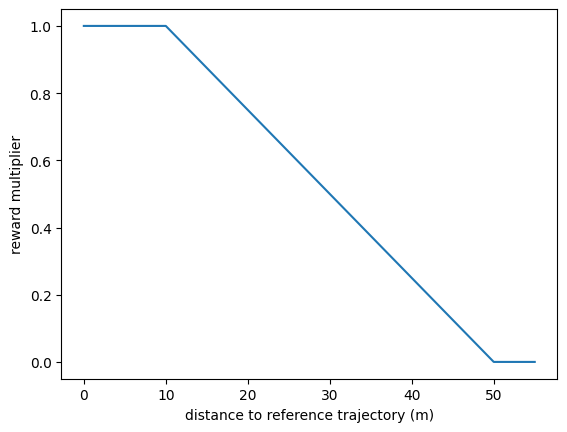

In [ ]:
#| label: fig-discount

import matplotlib.pyplot as plt
import numpy as np

discount_threshold = 10
max_distance = 50


@np.vectorize
def distance_discount(distance):
    if distance < discount_threshold:
        return 1.0
    elif max_distance < distance:
        return 0.0
    return 1.0 - (distance - discount_threshold) / (max_distance - discount_threshold)


x = np.linspace(0, max_distance * 1.1, 100)
plt.xlabel("distance to reference trajectory (m)")
plt.ylabel("reward multiplier")
plt.plot(x, distance_discount(x))
plt.show()

### Completing the map

Completing the map gives the AI a bigger reward. We have to make this reward big because the AI won't get further reward after finishing the map. If this reward is too low, the risk is that during training, the AI prefer to miss the finish in the hope to get more reward later.

PedroAI tackles this issue by giving the AI a reward equivalent to its expected return if it were to follow a reference trajectory perfectly at its current speed.

Remember that the expected return, or expected cumulative reward is computed as follows:

![](reward_gamma_sum.svg)

PedroAI's formula for map completion reward is:

![](map_completion_reward.svg)

This way, the finish reward is almost always larger than what the AI might expect if it was still driving along a trajectory. Additionally, it incentivise the AI to cross the finish line with maximum speed.

This approach generally results in faster completion times, but there is a drawback in that the AI may sometimes choose longer routes to gain more speed before finishing.

### Mistake state

The AI gets a small penalty for being in a mistake state. There are two possible mistakes:

- Being too far from the trajectory: the distance between the car and his projection on the reference trajectory is more than 50 meters.
- Not making progress on the reference trajecory: the car already got farther on the trajectory before during the round.

PedroAI gives a penalty of ≈14 points, which correspond to the amount of point the AI would get if it was driving at 50km/h following the reference trajectory. I tuned this value and found out that -14 yields the best results.

### Respawn or end round

If the AI is in a mistake state for more than 4 seconds, it respawns.

From the point of vue of the AI, that is where the round ends; it doesn't know that it is instead only respawning. For those familiar with reinforcement learning, from the pov of the AI, this is the end of the episode, but for the in-game round and my satistics, this is only a respawn.

If the AI respawns 4 times on the same checkpoint and finds itself in a mistake state for more than 4 seconds again, it will end the round for good.

Similar to map completion reward, when the AI must respawn or end the round, PedroAI gives it the expected return if the AI where to stay in a mistake state indefinitely.

![](respawn_reward.svg)

Now, you should have a better understanding of how PedroAI works. In summary:

- PedroAI uses an adapted version of Deep Q-Learning with four seperate workers, three to collect experiences and one to learn from those experiences.
- The neural network estimates the expected discounted cumulative rewards directly with one state. It doesn't need to predict everything that will happen in the future. When learning, the trick is to reuse the neural network on the next state to estimate the future rewards.
- The true Trackmania reward "complete the map in the minimum amount of time possible" is too sparse for reinforcement learning. PedroAI uses a denser reward function leveraging author or wr trajectory.

Stay tuned for the third blog post in this series where I present the technical details of the project: neural network architecture, frameworks, telemtry data gathering, and more ... I am still working on it 🤓